In [182]:
# Parameters for CNN
classNames: list = ['お','き','す', 'つ', 'な', 'は', 'ま', 'や', 'れ', 'を'] # duomenų klasės
numClasses: int = len(classNames) # Duomenų klasių skaičius
imageSize: int = 28 # Paveikslėlio dydis
dataSet: int  = 70000 # Duomenų rinkinio dydis
activationFunction: str = "relu" # Aktyvacijos funkcija
lossFunction = "categorical_crossentropy" # Loss function
modelFileName: str = "model.h5" # Modelio failo pavadinimas

#training data
testSize: float = 0.1 # Testavimo duomenų dydis
validationSize: float = 0.1 # Validavimo duomenų dydis
batchSize: int = 100 # 
epochs: int = 15 # Epochų skaičius
learningRate: float = 0.005 # Mokymo greitis
momentum: float = 0.8 # 
dropout: float = 0.2 # Išmetimo sluoksnio tikimybė

In [181]:
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib.figure import Figure
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, TensorBoard
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from mnist import MNIST

plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

In [200]:
# # Nuskaitoma informacija is failo
def getData() -> (list, list):
    mndata = MNIST('samples')
    imagesTrain, labelsTrain = mndata.load_training()
    imagesTest, labelsTest = mndata.load_testing()
    return imagesTrain+imagesTest, labelsTrain+labelsTest

# išskaidyti duomenų aibę į mokymo ir testavimo aibes
def splitData(data:list, labels:list, validationSize: float, testSize: float) -> (list, list, list, list, list, list):
    trainData, testData, trainLabels, testLabels = train_test_split(data, labels, test_size=testSize, random_state=42)
    trainData, validationData, trainLabels, validationLabels = train_test_split(trainData, trainLabels, test_size=validationSize, random_state=42)
    return trainData, validationData, testData, trainLabels, validationLabels, testLabels

# Suformuoti masyvus [0,0...1,...0,0], kur vienetas reiškia esamą duomenų klasės reikšmę.
def reshapeLabels(labels: list, numClasses: int) -> list:
    return [ [1 if i == label else 0 for i in range(numClasses)] for label in labels]

# Duomenų aibės elementus padaliname is 255, kad patektų į intevalą [0,1].
def normalizeData(data: list) -> list:
    data = np.array(data)
    return [ i / 255.0 for i in data]

# Duomenų aibę, nuskaitytą iš failo paverčiame į [10000,32,32,3] masyvą, kur 10000 - paveikslėlių kiekis duomenų faile, 32 - paveikslėlio aukštis ir plotis, 3 - RGB spalvu reikšmės.
def reshapeData(data: list, imageSize: int) -> list:
    modifiedData: [[[float]]] = []
    for i in data:
        imageMatrix: [[float]] = []
        for j in range(imageSize):
            combList : [float] = []
            for k in range(imageSize):
                combList.append(i[j*imageSize+k])
            imageMatrix.append(combList)
        modifiedData.append(imageMatrix)
    return modifiedData

# nuskaitomi visi failai, kuriuose yra duomenys, juos performatuojam ir išsaugome į kitus failus.
def prepareData(imageSize: int, numClasses: int) -> (list, list):
    newData: list = []
    newLabels: list = []
    data, labels = getData()
    data = normalizeData(data)
    data = reshapeData(data, imageSize)
    labels = reshapeLabels(labels, numClasses)
    newData.extend(data)
    newLabels.extend(labels)
    newData = np.array(newData)
    newLabels = np.array(newLabels)
    return newData, newLabels

def lenet() -> Sequential: # iki galo issiaiskinti kaip veikia
    model = Sequential()
    model.add(Conv2D(6, (5, 5), padding='valid', activation = activationFunction, kernel_initializer='he_normal', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # model.add(Dropout(dropout)) # 1
    model.add(Conv2D(16, (5, 5), padding='valid', activation = activationFunction, kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation = activationFunction, kernel_initializer='he_normal'))
    model.add(Dropout(dropout)) # 2
    model.add(Dense(84, activation = activationFunction, kernel_initializer='he_normal'))
    model.add(Dense(numClasses, activation = 'softmax', kernel_initializer='he_normal'))
    sgd = optimizers.legacy.SGD(learning_rate=learningRate, momentum=momentum, nesterov=True)
    model.compile(loss=lossFunction, optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model

# https://thecleverprogrammer.com/2021/12/13/alexnet-architecture-using-python/
def alexNet() -> Sequential:
    model = Sequential()
    model.add(Conv2D(96,(11, 11), activation=activationFunction, input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides= (2, 2)))
    model.add(Conv2D(256, (5, 5), strides=(1, 1), activation=activationFunction, padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Conv2D(384, (3, 3), strides=(1, 1), activation=activationFunction, padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(384, (3, 3), strides=(1, 1), activation=activationFunction, padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), strides=(1, 1), activation=activationFunction, padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4096, activation=activationFunction))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation="softmax"))
    sgd = optimizers.legacy.SGD(learning_rate=learningRate, momentum=momentum, nesterov=True)
    model.compile(loss=lossFunction, optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model

def simple() -> Sequential:
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activationFunction, kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activationFunction, kernel_initializer='he_normal'))
    model.add(Flatten())
    model.add(Dense(64, activation=activationFunction, kernel_initializer='he_normal'))
    model.add(Dense(10, activation='softmax', kernel_initializer='he_normal'))
    sgd = optimizers.legacy.SGD(learning_rate=learningRate, momentum=momentum, nesterov=True)
    model.compile(loss=lossFunction, optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model

def scheduler(epoch: int) -> float:
    if epoch < 100:
        return 0.01
    if epoch < 150:
        return 0.005
    return 0.001

# Modelio mokymas naudojantis mokymo ir testavimo duomenimis, bei pateikiant mokymo algorithmą.
def trainModel(trainData: np.array,validationData: np.array, trainLabels: np.array, validationLabels: np.array, learningModel: callable) -> list:
    model: Sequential = learningModel()
    print(model.summary())

    # set callback
    tensorBoard = TensorBoard(log_dir='./lenet', histogram_freq=0)
    change_lr = LearningRateScheduler(scheduler)
    cbks = [change_lr,tensorBoard]

    modelHistory = model.fit(trainData, trainLabels,
                batch_size=batchSize,
                epochs=epochs,
                callbacks=cbks,
                validation_data=(validationData, validationLabels),
                shuffle=True)

    model.save(modelFileName)
    return modelHistory
# Esamas duomenų klasės maskes paverčiame į klasės indeksą.
def labelToClass(label: list) -> int:
    for i in range(len(label)):
        if label[i] == 1:
            return i
# Turėdami tikimybes klasėms, kurias priskyrė modelis, paverčiame pasiimame klasės indeksą su didžiausią tikimybe.
def probabilityToClass(label:list) -> int:
    return np.argmax(label)

# Palyginame modelio spėjimus su tikromis klasėmis ir paskaičiuojame tikslumą.
def accuracy(predictions: list, labels: list) -> float:
    correct: int = 0
    for i in range(len(predictions)):
        if predictions[i] == labelToClass(labels[i]):
            correct += 1
    return correct / len(predictions)

# Palyginame modelio spėjimus su tikromis klasėmis ir paskaičiuojame vidutinį kvadratinį nuokrypį.
def loss(model: Sequential,data:np.array, labels: np.array) -> float:
    MSE:int = 0
    classesPredicted = [probabilityToClass(i) for i in model.predict(data)]
    for i in range(len(data)):
        MSE += np.square(labelToClass(labels[i]) - classesPredicted[i])
    return MSE / len(data)

# Nupiešiame modelio confusion matrix.
def confusionMatrix(model: Sequential, data: np.array, labels: np.array):
    predictions = model.predict(data)
    predictions = [probabilityToClass(i) for i in predictions]
    cm = confusion_matrix([labelToClass(i) for i in labels],predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize = (10,10))
    sns.heatmap(cm, annot=True, xticklabels=classNames, yticklabels = classNames, square=True, cmap='Greens')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

# Nupiešiame paveikslėlius ir jų spėjimus su tikimybėmis.
def drawImagesAndPredictions(model: Sequential, data: np.array, labels: np.array, rows:int=8, columns: int=8, startIndex: int=0):
    figure: Figure = plt.figure(figsize=(10, 7)) 

    nData: np.array = data[startIndex:startIndex+rows*columns]
    labels: np.array = labels[startIndex:startIndex+rows*columns]

    model = load_model(modelFileName)
    modelPredictions = model.predict(nData)
    modelPredictedClasses = [probabilityToClass(i) for i in modelPredictions]

    for i in range(len(nData)):
        figure.add_subplot(rows, columns, i+1)
        plt.imshow(nData[i],cmap='gray') 
        plt.axis('off')
        title = classNames[modelPredictedClasses[i]] + "\n (" + round(max(modelPredictions[i]),3).__str__() + ")"
        if modelPredictedClasses[i] != labelToClass(labels[i]):
            plt.title(title,color="red")
        else:
            plt.title(title,color="green")
        plt.tight_layout(pad=0.5)

In [170]:
data, labels = prepareData(imageSize, numClasses)

In [171]:
trainData, validationData, testData, trainLabels, validationLabels, testLabels = splitData(data, labels, validationSize, testSize)
history = trainModel(trainData,testData,trainLabels,testLabels, lenet)

print("Train data accuracy: ", history.history['accuracy'][-1])
print("Train data loss: ", history.history['loss'][-1])
print("Test data accuracy: ", history.history['val_accuracy'][-1])
print("Test data loss: ", history.history['val_loss'][-1])

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 12, 12, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 4, 4, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 256)               0         
                                                                 
 dense_60 (Dense)            (None, 120)             

In [185]:
model = load_model(modelFileName)

In [186]:
predictionValues = model.predict(testData)
predictionValues = [probabilityToClass(i) for i in predictionValues]
print("Test data accuracy: ", history.history['val_accuracy'][-1])
print("Test data loss: ", history.history['val_loss'][-1]
print("accuracy: ", accuracy(predictionValues, testLabels))
print("loss: ", loss(model, testData, testLabels))

219/219 [==============================] - 3s 13ms/step
accuracy:  0.9882857142857143
219/219 [==============================] - 3s 13ms/step
loss:  0.22957142857142857


219/219 [==============================] - 3s 13ms/step


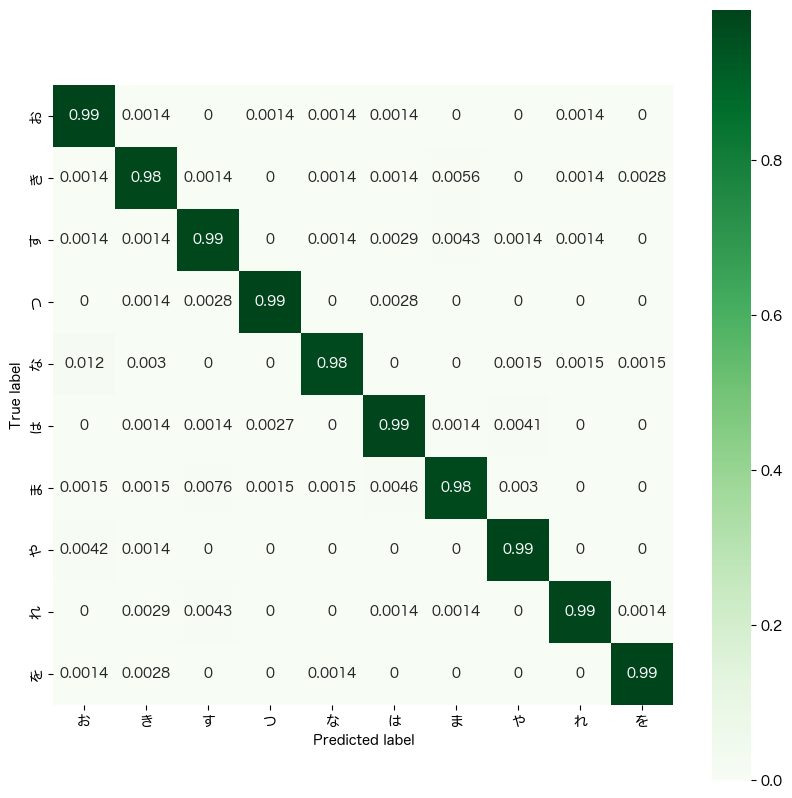

In [187]:
confusionMatrix(model, testData, testLabels)

[0, 3, 9, 4, 5, 0, 6, 0, 5, 3, 9, 0, 4, 3, 2, 9, 3, 3, 9, 5, 1, 8, 8, 3, 5, 3, 1, 1, 2, 8]
1  &  お  &  お  \\ \hline
2  &  つ  &  つ  \\ \hline
3  &  を  &  を  \\ \hline
4  &  な  &  な  \\ \hline
5  &  は  &  は  \\ \hline
6  &  お  &  お  \\ \hline
7  &  は  &  ま  \\ \hline
8  &  お  &  お  \\ \hline
9  &  は  &  は  \\ \hline
10  &  つ  &  つ  \\ \hline
11  &  を  &  を  \\ \hline
12  &  お  &  お  \\ \hline
13  &  な  &  な  \\ \hline
14  &  つ  &  つ  \\ \hline
15  &  す  &  す  \\ \hline
16  &  を  &  を  \\ \hline
17  &  つ  &  つ  \\ \hline
18  &  つ  &  つ  \\ \hline
19  &  を  &  を  \\ \hline
20  &  ま  &  は  \\ \hline
21  &  き  &  き  \\ \hline
22  &  す  &  れ  \\ \hline
23  &  れ  &  れ  \\ \hline
24  &  つ  &  つ  \\ \hline
25  &  は  &  は  \\ \hline
26  &  つ  &  つ  \\ \hline
27  &  き  &  き  \\ \hline
28  &  き  &  き  \\ \hline
29  &  す  &  す  \\ \hline
30  &  れ  &  れ  \\ \hline
1/1 [==============================] - 0s 66ms/step


/var/folders/2d/3vb6hz_s28z4y7mpqyhs8nbw0000gq/T/ipykernel_29147/196583813.py:189: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.5)


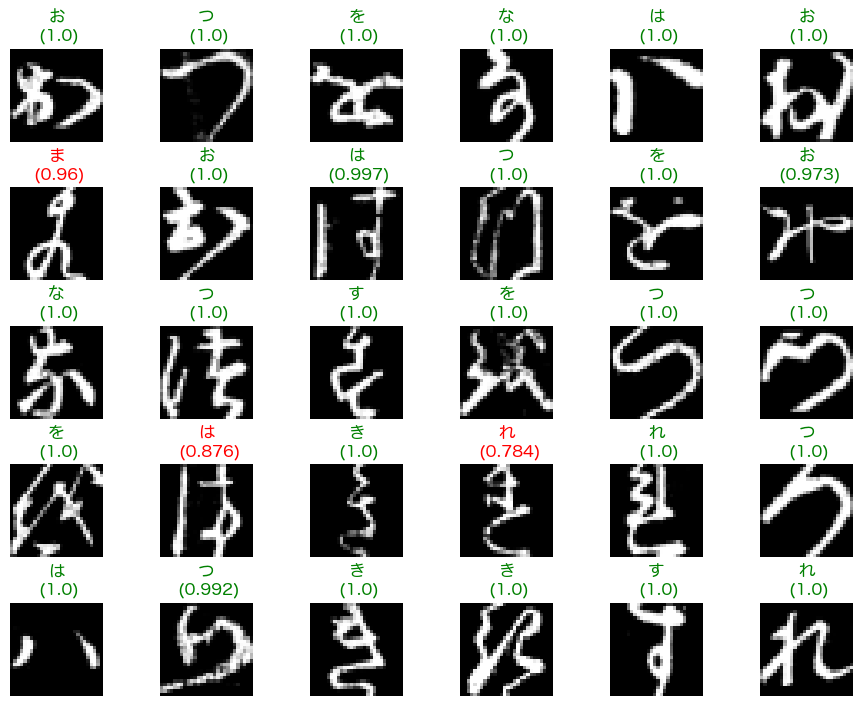

In [209]:
rangeStart = 230
rangeEnd = 260
print(predictionValues[rangeStart:rangeEnd])
labels = [probabilityToClass(i) for i in testLabels]
# for i in range(len(labels)):
#     if labels[i] != predictionValues[i]:
#         print(i)
# print (labels[rangeStart:rangeEnd])
for i in range(rangeStart, rangeEnd):
  print(i-229, ' & ',  classNames[labels[i]], ' & ', classNames[predictionValues[i]], ' \\\\ \hline')
drawImagesAndPredictions(model, testData, testLabels, 5,6, rangeStart)

In [176]:
lenetHistory = trainModel(trainData,testData,trainLabels,testLabels, lenet)
simpleHistory = trainModel(trainData,testData,trainLabels,testLabels, simple)
# alexNetHistory = trainModel(trainData,testData,trainLabels,testLabels, alexNet)




Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 12, 12, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_73 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 4, 4, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_25 (Flatten)        (None, 256)               0         
                                                                 
 dense_63 (Dense)            (None, 120)             

/Users/pijus/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


567/567 [==============================] - 6s 11ms/step - loss: 0.5066 - accuracy: 0.8415 - val_loss: 0.2294 - val_accuracy: 0.9300 - lr: 0.0100
Epoch 2/15
567/567 [==============================] - 6s 11ms/step - loss: 0.1971 - accuracy: 0.9409 - val_loss: 0.1631 - val_accuracy: 0.9491 - lr: 0.0100
Epoch 3/15
567/567 [==============================] - 6s 11ms/step - loss: 0.1377 - accuracy: 0.9591 - val_loss: 0.1290 - val_accuracy: 0.9593 - lr: 0.0100
Epoch 4/15
567/567 [==============================] - 6s 11ms/step - loss: 0.1057 - accuracy: 0.9688 - val_loss: 0.1074 - val_accuracy: 0.9670 - lr: 0.0100
Epoch 5/15
567/567 [==============================] - 6s 11ms/step - loss: 0.0867 - accuracy: 0.9739 - val_loss: 0.1020 - val_accuracy: 0.9693 - lr: 0.0100
Epoch 6/15
567/567 [==============================] - 6s 11ms/step - loss: 0.0716 - accuracy: 0.9782 - val_loss: 0.0866 - val_accuracy: 0.9717 - lr: 0.0100
Epoch 7/15
567/567 [==============================] - 6s 11ms/step - loss: 

KeyboardInterrupt: 

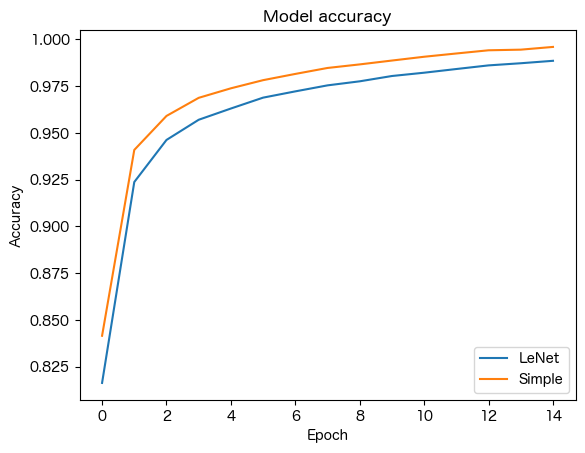

/var/folders/2d/3vb6hz_s28z4y7mpqyhs8nbw0000gq/T/ipykernel_29147/2769368504.py:11: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.gca().set_ylim(bottom=1)


Text(0.5, 0, 'Epoch')

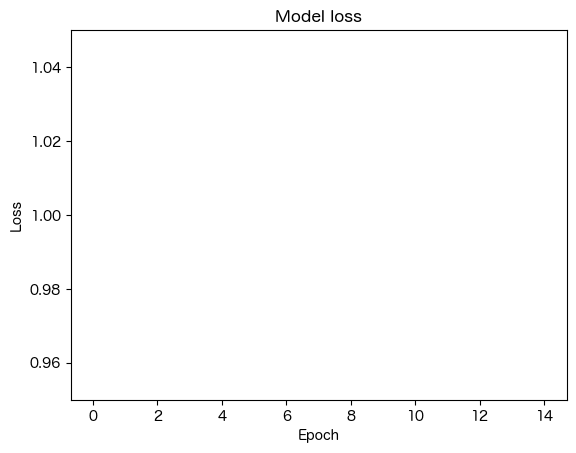

In [180]:
plt.plot(lenetHistory.history['accuracy'])
plt.plot(simpleHistory.history['accuracy'])
# plt.plot(alexNetHistory.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# add legend
plt.legend(['LeNet', 'Simple'], loc='lower right')
plt.show()
# make axis start at 1 x-axis

plt.plot(lenetHistory.history['loss'])
plt.plot(simpleHistory.history['loss'])
# plt.plot(alexNetHistory.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')